In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from tqdm import tqdm 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
data_dir = 'D:/datasets/DL/Animals/raw-img'  
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = len(dataset.classes) 
model.fc = nn.Linear(num_ftrs, num_classes) 

C:\Users\Tanmay LImje\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Tanmay LImje\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model = model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=0.001)

In [10]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    model.train()  # Set model to training mode

    running_loss = 0.0
    running_corrects = 0
    total_batches = len(train_loader)

    # Use tqdm to wrap the train_loader for the progress bar
    with tqdm(train_loader, unit="batch") as tbar:
        tbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

        for inputs, labels in tbar:
            inputs = inputs.to(device)  # Transfer inputs to GPU
            labels = labels.to(device)  # Transfer labels to GPU

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Update tqdm progress bar with current loss
            tbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

Epoch 0/9


Epoch 1/10: 100%|██████████| 655/655 [02:22<00:00,  4.60batch/s, loss=0.397] 


Training Loss: 0.2404 Acc: 0.9361
Epoch 1/9


Epoch 2/10: 100%|██████████| 655/655 [02:10<00:00,  5.00batch/s, loss=0.0389] 


Training Loss: 0.1397 Acc: 0.9573
Epoch 2/9


Epoch 3/10: 100%|██████████| 655/655 [02:11<00:00,  5.00batch/s, loss=0.0749] 


Training Loss: 0.1271 Acc: 0.9602
Epoch 3/9


Epoch 4/10: 100%|██████████| 655/655 [02:12<00:00,  4.96batch/s, loss=0.0284]  


Training Loss: 0.1197 Acc: 0.9632
Epoch 4/9


Epoch 5/10: 100%|██████████| 655/655 [02:09<00:00,  5.06batch/s, loss=0.00339]


Training Loss: 0.1146 Acc: 0.9623
Epoch 5/9


Epoch 6/10: 100%|██████████| 655/655 [02:09<00:00,  5.07batch/s, loss=0.482]  


Training Loss: 0.1107 Acc: 0.9658
Epoch 6/9


Epoch 7/10: 100%|██████████| 655/655 [02:09<00:00,  5.06batch/s, loss=0.247]   


Training Loss: 0.1054 Acc: 0.9669
Epoch 7/9


Epoch 8/10: 100%|██████████| 655/655 [02:09<00:00,  5.07batch/s, loss=0.113]  


Training Loss: 0.1061 Acc: 0.9661
Epoch 8/9


Epoch 9/10: 100%|██████████| 655/655 [02:10<00:00,  5.04batch/s, loss=0.217]  


Training Loss: 0.1025 Acc: 0.9676
Epoch 9/9


Epoch 10/10: 100%|██████████| 655/655 [02:09<00:00,  5.07batch/s, loss=0.0153] 

Training Loss: 0.0972 Acc: 0.9710


In [11]:

# Evaluation
model.eval()  # Set model to evaluation mode
running_corrects = 0

with torch.no_grad():
    with tqdm(val_loader, unit="batch", desc="Validation") as vbar:
        for inputs, labels in vbar:
            inputs = inputs.to(device)  # Transfer inputs to GPU
            labels = labels.to(device)  # Transfer labels to GPU

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

val_acc = running_corrects.double() / len(val_dataset)
print(f'Validation Accuracy: {val_acc:.4f}')


Validation: 100%|██████████| 164/164 [00:24<00:00,  6.73batch/s]

Validation Accuracy: 0.9708


The predicted class is: cavallo


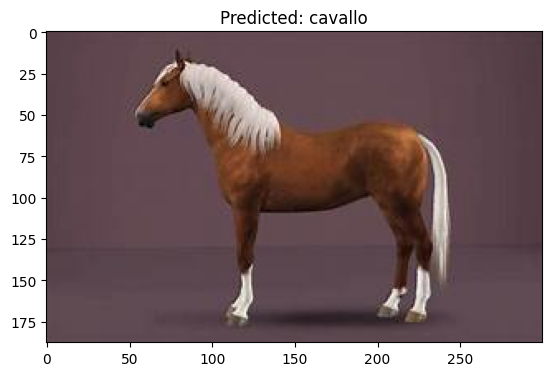

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

# Define a function for image preprocessing (same as the transformation used for validation)
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')  # Open the image and convert it to RGB
    image = transform(image)  # Apply transformations
    return image.unsqueeze(0)  # Add a batch dimension

# Function to predict the class of a single image
def predict_image(image_path, model, class_names):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        # Preprocess the image
        image_tensor = preprocess_image(image_path).to(device)

        # Forward pass through the model
        outputs = model(image_tensor)

        # Get the predicted class (index of the highest score)
        _, predicted_idx = torch.max(outputs, 1)

        # Get the class name from the predicted index
        predicted_class = class_names[predicted_idx.item()]

        return predicted_class

# Example usage:
image_path = "D:/datasets/DL/Animals/raw-img/cavallo/OIP-_6poWqxKgI1r0BVX9xCTaQHaEo.jpeg"  # Replace with the path of the image you want to predict
class_names = dataset.classes  # List of class names (from ImageFolder)
predicted_class = predict_image(image_path, model, class_names)

print(f'The predicted class is: {predicted_class}')

# Optionally, show the image
img = Image.open(image_path)
plt.imshow(img)
plt.title(f'Predicted: {predicted_class}')
plt.show()